In [1]:
import apriltag
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
import glob
from scipy.optimize import minimize, least_squares
from scipy.spatial.transform import Rotation as scipy_R

In [2]:
%matplotlib inline

In [54]:
def calculate_Tr(K_np, rvec_np, tvec_np):
    _R_cv2bcam = np.array([[1,0,0],
                       [0,-1,0],
                       [0,0,-1]])
    R, _ = cv2.Rodrigues(rvec_np)
    # t = tvec_np[_i]/100. #(mm to M)? scale problem exist.
    t = tvec_np/100. #(mm to M)? scale problem exist.
    # k = first_K_np
    R_bcam= np.matmul(_R_cv2bcam, R)
    T_bcam = np.matmul(_R_cv2bcam, t)                       
    R_world = R_bcam.transpose()
    T_world = -np.matmul(R_world, T_bcam)

    R_world = R_world.reshape(3,3)
    T_world = T_world.reshape(3,1)

    Tr = np.identity(4)
    Tr[:3,:3] = R_world
    Tr[:3,3:] = T_world

    return Tr# debugging image is not nessesary, apriltag detection already confirmed.

# APRILTAG IMAGE LOAD

In [4]:
img = cv2.imread('/workspace/multiview_calibration/ros-apriltag-board.png', cv2.IMREAD_GRAYSCALE)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
print(img.shape)
#april_sample.png
detector = apriltag.Detector()
base_result = detector.detect(img)

(2100, 2800)


In [5]:
blue = [255,0,0]
red = [0,0,255]
greed = [0,255,0]
purple = [255,0,255]

colors = [blue, red, greed, purple]
num_detection = len(base_result)

img_plot = cv2.imread('/workspace/multiview_calibration/ros-apriltag-board.png')
img_plot = cv2.rotate(img_plot, cv2.ROTATE_90_COUNTERCLOCKWISE)

for i_tag in range(num_detection):
    
    one_tag = base_result[i_tag]
    one_tagname = base_result[i_tag].tag_family
    one_corners = base_result[i_tag].corners
    
    for i_corner in range(4):
        img_plot = cv2.circle(img_plot, (int(one_corners[i_corner,0]),int(one_corners[i_corner,1])), 0, colors[i_corner], 30)

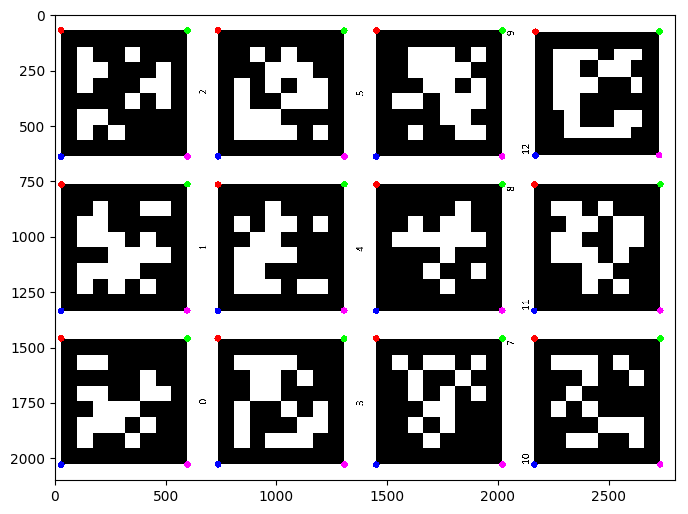

In [6]:
fig=plt.figure(figsize=(8,12), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img_plot[:,:,::-1])

# LOAD INTRINSIC RESULTS

In [9]:
# 22240376_intrinsic_result.npz
# load intrinsic result from npz file
#left_22240382_right_22240376
left_serial = '22240382'
right_serial = '22240376'
data_root = '/workspace/multiview_calibration/MULTIVIEW/cal_image'

left_npz_file = np.load(os.path.join(data_root, 'intrinsic_images', left_serial + '_intrinsic_result.npz'))
left_mtx = left_npz_file['mtx']
left_dist = left_npz_file['dist']
left_rvecs = left_npz_file['rvecs']
left_tvecs = left_npz_file['tvecs']

right_npz_file = np.load(os.path.join(data_root, 'intrinsic_images', right_serial + '_intrinsic_result.npz'))
right_mtx = right_npz_file['mtx']
right_dist = right_npz_file['dist']
right_rvecs = right_npz_file['rvecs']
right_tvecs = right_npz_file['tvecs']

# LOAD STEREO CALIBRATION IMAGE

In [16]:
# load stereo calibration image form directory

# /workspace/multiview_calibration/MULTIVIEW/cal_image/extrinsic_images/left_22240382_right_22240376
stereo_root = '/workspace/multiview_calibration/MULTIVIEW/cal_image/extrinsic_images/left_22240382_right_22240376'
left_image_dir = os.path.join(stereo_root, 'left_'+left_serial)
left_image_list = glob.glob(os.path.join(left_image_dir, '*.jpg'))
left_image_list.sort()
right_image_dir = os.path.join(stereo_root, 'right_'+right_serial)
right_image_list = glob.glob(os.path.join(right_image_dir, '*.jpg'))
right_image_list.sort()

left_basename_list = [os.path.basename(x) for x in left_image_list]
right_basename_list = [os.path.basename(x) for x in right_image_list]
assert left_basename_list == right_basename_list, 'left and right image list are not matched'

In [17]:
# prepare parameters for cv2.stereoCalibrate
# prepare object points, image points of left, image points of right and image size
# read left, right image from directory

rescale_factor = 0.5

num_image = len(left_image_list)

left_detector = apriltag.Detector()
right_detector = apriltag.Detector()

april_objpoints = []
left_april_imgpoints = []
right_april_imgpoints = []
april_imagename = []

for i in range(num_image):
    left_image = cv2.imread(left_image_list[i])
    right_image = cv2.imread(right_image_list[i])
    # resize image with rescale_factor
    left_image_resized = cv2.resize(left_image, None, fx=rescale_factor, fy=rescale_factor)
    right_image_resized = cv2.resize(right_image, None, fx=rescale_factor, fy=rescale_factor)
    # convert to gray scale
    left_image_gray = cv2.cvtColor(left_image_resized, cv2.COLOR_BGR2GRAY)
    right_image_gray = cv2.cvtColor(right_image_resized, cv2.COLOR_BGR2GRAY)
    # find apriltag
    left_result = left_detector.detect(left_image_gray)
    right_result = right_detector.detect(right_image_gray)
    num_left_tag = len(left_result)
    num_right_tag = len(right_result)
    assert num_left_tag == num_right_tag==12, 'left and right tag number are not matched or not 12'
    # synthesis objpoints and imgpoints
    left_imgpoints = []
    right_imgpoints = []
    apriltag_objp = []

    for i_tag in range(len(left_result)):
        left_one_tag = left_result[i_tag]
        left_one_tag_id = left_one_tag.tag_id
        left_one_corners = left_one_tag.corners
        left_one_corners /= rescale_factor # rescale corners
        left_imgpoints.append(left_one_corners)

        right_one_tag = right_result[i_tag]
        right_one_tag_id = right_one_tag.tag_id
        right_one_corners = right_one_tag.corners
        right_one_corners /= rescale_factor # rescale corners
        right_imgpoints.append(right_one_corners)

        base_one_tag = base_result[left_one_tag_id]
        base_one_corners = base_one_tag.corners
        apriltag_objp.append(base_one_corners)

    # april_imgpt = np.array(april_imgpt)
    # april_imgpt = april_imgpt.reshape(-1, 1, 2)
    # april_imgpoints.append(april_imgpt.astype(np.float32))
    left_imgpoints = np.array(left_imgpoints)
    left_imgpoints = left_imgpoints.reshape(-1, 1, 2)
    left_imgpoints = left_imgpoints.astype(np.float32)
    left_april_imgpoints.append(left_imgpoints)
    right_imgpoints = np.array(right_imgpoints)
    right_imgpoints = right_imgpoints.reshape(-1, 1, 2)
    right_imgpoints = right_imgpoints.astype(np.float32)
    right_april_imgpoints.append(right_imgpoints)

    apriltag_objp = np.array(apriltag_objp)
    apriltag_objp = apriltag_objp.reshape(-1,2)
    _zeros = np.zeros([apriltag_objp.shape[0],1])
    apriltag_objp = np.concatenate([apriltag_objp, _zeros], axis=1)
    apriltag_objp *= 50/(597.00000089 - 27.99999955)
    april_objpoints.append(apriltag_objp.astype(np.float32))
    april_imagename.append(left_basename_list[i])


In [22]:
left_image_resized.shape[::-1]

(3, 1024, 768)

In [30]:
print(len(april_objpoints))
print(april_objpoints[0].shape)

print(len(left_april_imgpoints))
print(left_april_imgpoints[0].shape)

print(left_image.shape[:2][::-1])

117
(48, 3)
117
(48, 1, 2)
(2048, 1536)


In [39]:
# randomly sample a subset of april_imgpoints and april_objpoints and april_imagename. no duplicated.
num_sample = 40
total_num = len(april_objpoints)
assert total_num >= num_sample, 'total number of april_imgpoints is less than num_sample'
sample_idx = np.random.choice(total_num, num_sample, replace=False)
left_april_imgpoints_sampled = [left_april_imgpoints[i] for i in sample_idx]
right_april_imgpoints_sampled = [right_april_imgpoints[i] for i in sample_idx]
april_objpoints_sampled = [april_objpoints[i] for i in sample_idx]
april_imagename_sampled = [april_imagename[i] for i in sample_idx]


In [33]:
# just intrinsic calibration for debug
# left_ret, left_mtx, left_dist, left_rvecs, left_tvecs = cv2.calibrateCamera(april_objpoints, left_april_imgpoints, left_image.shape[:2][::-1], None, None)

# 1.5343584670449189
# [[2.20554484e+03 0.00000000e+00 9.85254599e+02]
#  [0.00000000e+00 2.21890933e+03 7.94500597e+02]
#  [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

In [40]:
#change this if stereo calibration not good.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC
(width, height) = left_image.shape[:2][::-1]
print(width, height)

2048 1536


In [42]:
ret, CM1, dist1, CM2, dist2, R, T, E, F = cv2.stereoCalibrate(april_objpoints, left_april_imgpoints, right_april_imgpoints, left_mtx, left_dist,
                                                                 right_mtx, right_dist, (width, height), criteria = criteria, flags = stereocalibration_flags)

In [44]:
print('ret:', ret)
print('CM1:', CM1)
print('dist1:', dist1)
print('CM2:', CM2)
print('dist2:', dist2)
print('R:', R)
print('T:', T)
print('E:', E)
print('F:', F)

ret: 3.935681907670002
CM1: [[2.20554484e+03 0.00000000e+00 9.85254599e+02]
 [0.00000000e+00 2.21890933e+03 7.94500597e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist1: [[-0.37449826  0.73174348 -0.00593855  0.04171091 -0.8665762 ]]
CM2: [[3.57640259e+03 0.00000000e+00 1.00893368e+03]
 [0.00000000e+00 3.49744438e+03 7.58159866e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist2: [[-2.85214781e-01  3.84871039e+00  2.61102481e-03  3.08833036e-03
  -2.07304200e+01]]
R: [[ 0.97009068 -0.242703    0.00439516]
 [ 0.24020613  0.96240659  0.12678551]
 [-0.03500115 -0.1219377   0.99192042]]
T: [[-560.97631315]
 [-174.96642582]
 [ 304.3080625 ]]
E: [[ -66.97263453 -271.53308169 -212.13462433]
 [ 275.57159809 -142.26064277  557.78134127]
 [  34.9833517  -582.35217893  -70.35466496]]
F: [[-2.05874147e-07 -8.29666424e-07 -5.76232797e-04]
 [ 8.66232490e-07 -4.44489101e-07  3.36673821e-03]
 [-6.44267207e-05 -5.18967431e-03  1.00000000e+00]]


In [53]:
rvec_cam = scipy_R.from_matrix(R).as_rotvec().reshape(3,1)
tvec_cam = T.reshape(3,1)


In [64]:
Tr_origin = calculate_Tr(K_np=None, rvec_np=np.array([.0,.0,.0]), tvec_np=np.array([.0,.0,.0]))
Tr_trans = calculate_Tr(K_np=None, rvec_np=rvec_cam, tvec_np=tvec_cam)

In [66]:
# /workspace/multiview_calibration/MULTIVIEW/cal_image/extrinsic_images/left_22240382_right_22240376
extrinsic_Tr_dir = os.path.join(data_root, 'extrinsic_images', 'left_' + left_serial + '_right_' + right_serial)
print(extrinsic_Tr_dir)

/workspace/multiview_calibration/MULTIVIEW/cal_image/extrinsic_images/left_22240382_right_22240376


In [67]:
np.save(os.path.join(extrinsic_Tr_dir, 'origin_Tr.npy'), Tr_origin)
np.save(os.path.join(extrinsic_Tr_dir, 'left_' + left_serial + '_right_' + right_serial+'_Tr.npy'), Tr_trans)